In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits
from matplotlib import cm


In [2]:
os.chdir('/home/walml/repos/agnfinder')

In [4]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
# save_dir = 'results/emulated_sampling/30k_burnin'
# save_dir = 'results/emulated_sampling/latest_100000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_100000_64_optimised'

# all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')

all_galaxy_locs = ['results/emulated_sampling/long_emcee/100k_samples_256_walkers_10x.h5']


assert all_galaxy_locs
print(len(all_galaxy_locs))


extra_thinning = 1

1


In [5]:
# open one galaxy for params
with h5py.File(all_galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

marginal_bins = 50
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)
                
galaxies = []
true_observations = len(all_galaxy_locs)
# for n, galaxy_loc in enumerate(galaxy_locs[0:]):  # thinned
for n, galaxy_loc in enumerate(all_galaxy_locs):  # thinned
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
#             if f['is_accepted'][...].mean() < 0.6:
#                 print(f['is_accepted'])
#             else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::extra_thinning]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
                    'fixed_params': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...],
                }
                
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [6]:
galaxy['samples'].shape

(25600000, 8)

In [7]:
galaxy = galaxies[0]

In [8]:
# galaxy_locs = [x for x in all_galaxy_locs if 'galaxy__' in x]

In [9]:
# galaxy_locs

In [11]:
n_chains = 256
# n_chains = 64
# n_chains = 1
by_chain = np.reshape(galaxy['samples'], (-1, n_chains, 8))

(100000, 256, 8)

In [12]:
# by_chain = np.stack([np.squeeze(g['samples']) for g in galaxies], axis=1)
# by_chain.shape

In [13]:
by_chain.shape

(100000, 256, 8)

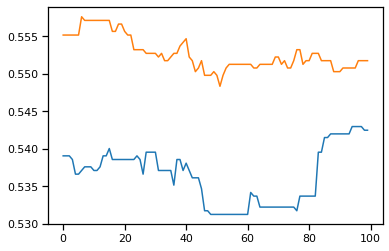

In [14]:
plt.plot(by_chain[:100, 0, 0])
plt.plot(by_chain[:100, 1, 0])

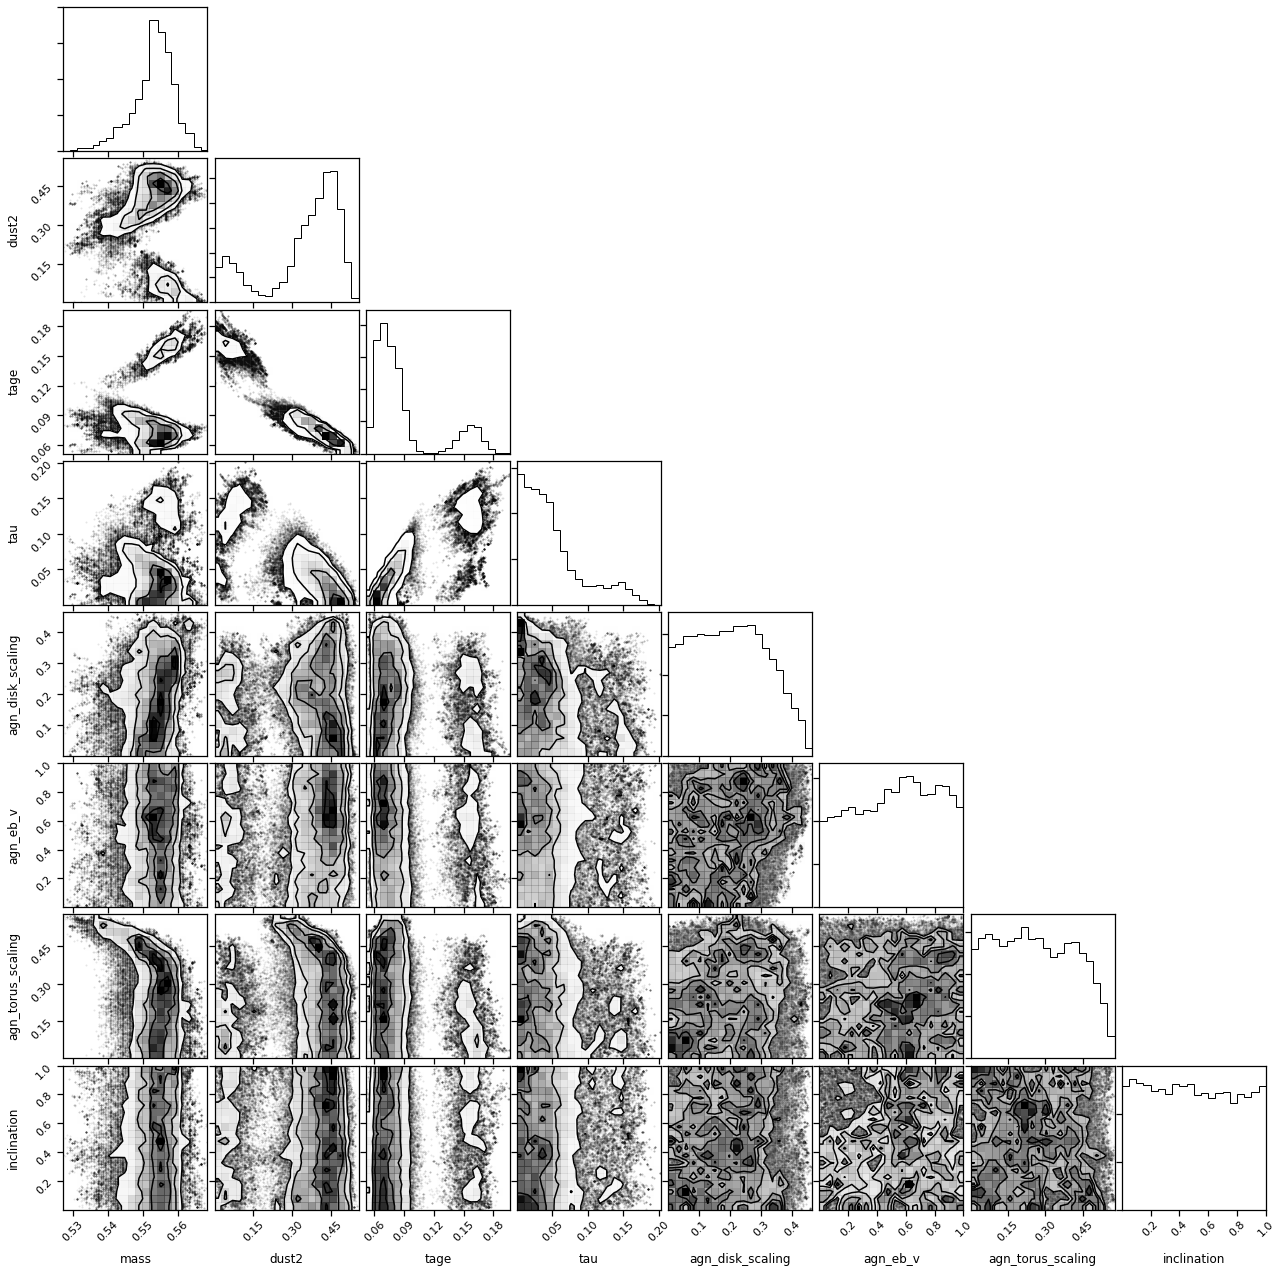

In [15]:
_ = corner.corner(by_chain[:, 0, :], labels=params)

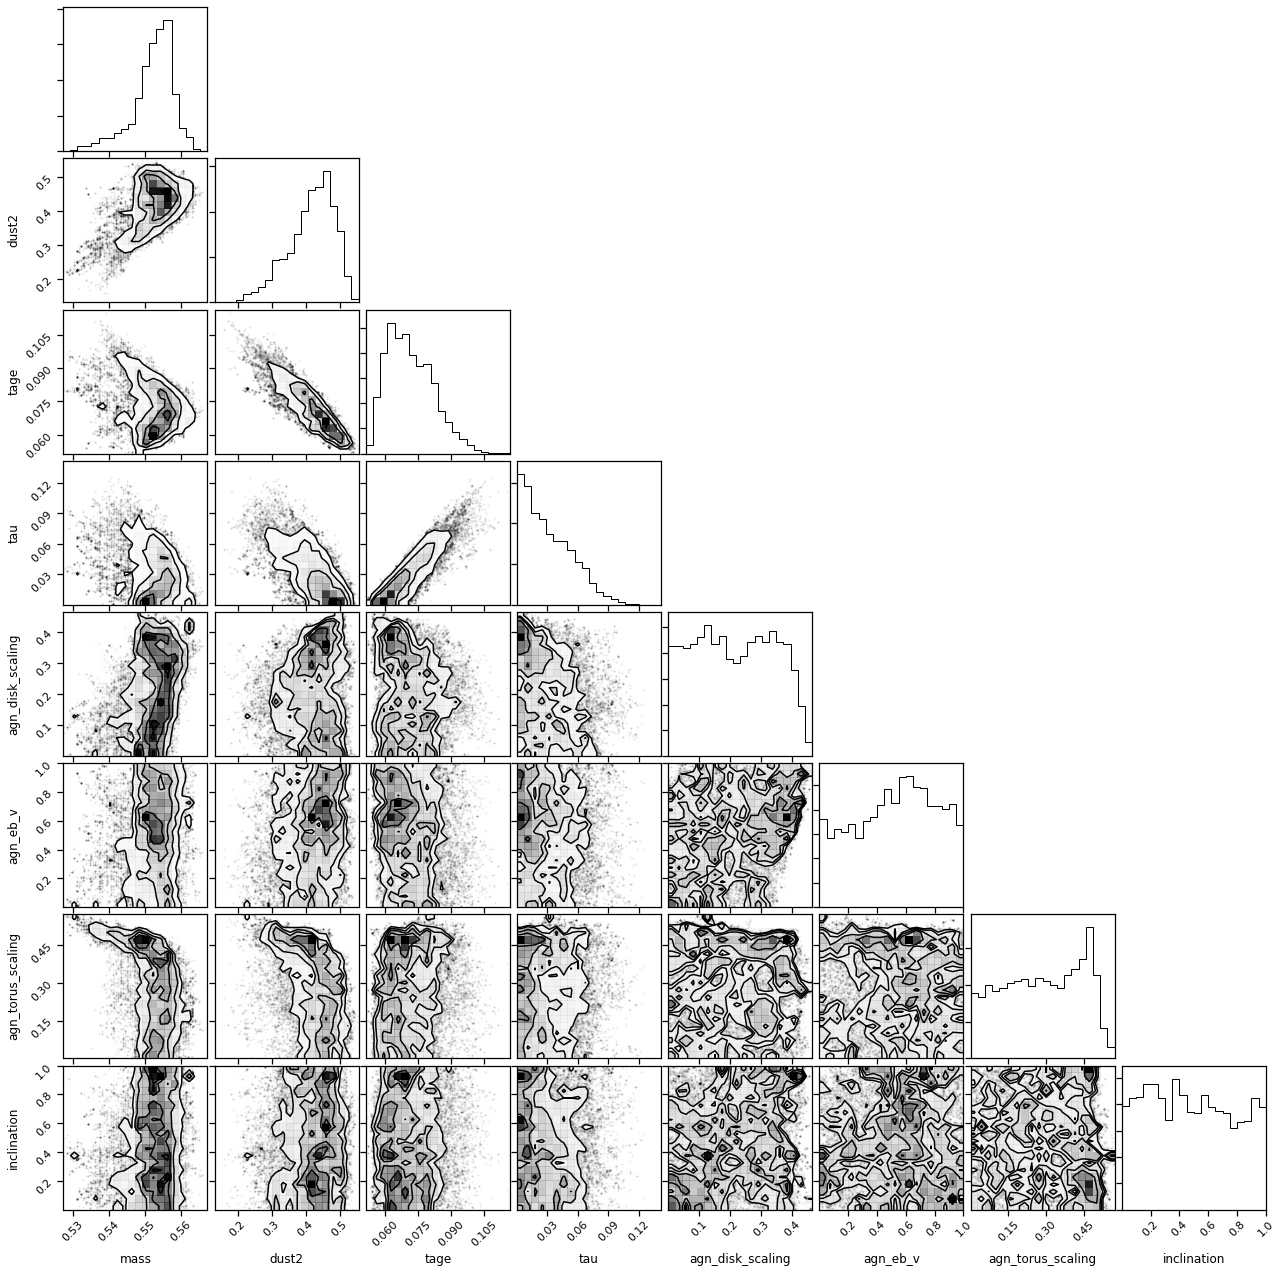

In [16]:
_ = corner.corner(by_chain[:20000, 0, :], labels=params)

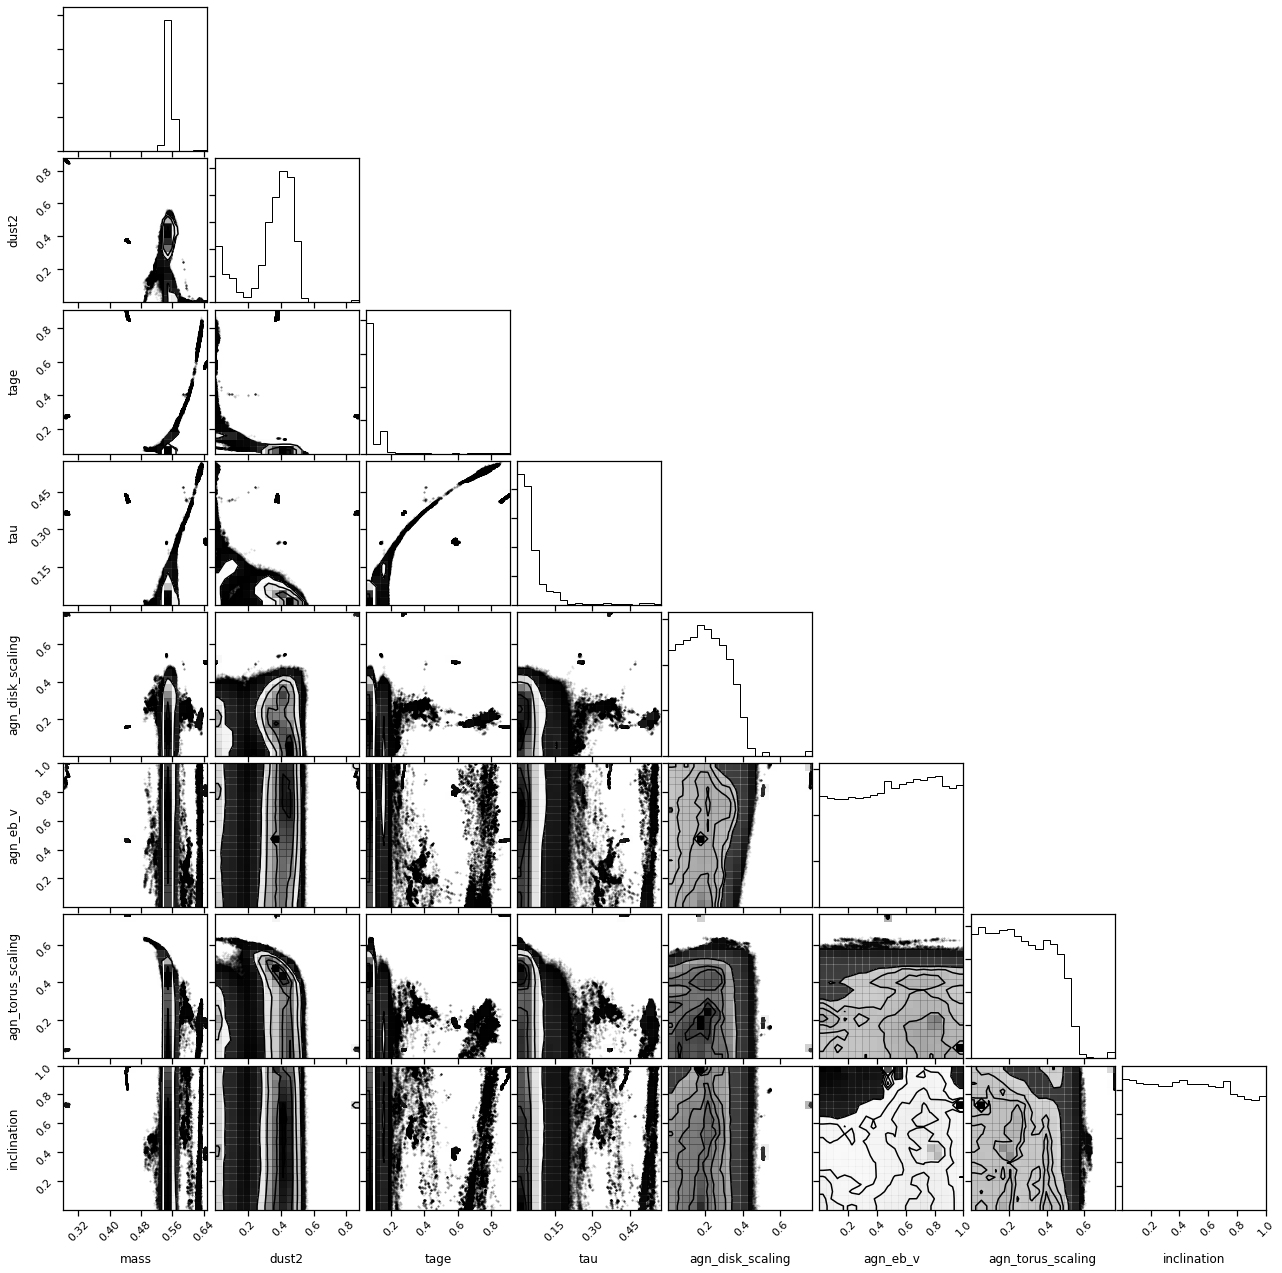

In [17]:
_ = corner.corner(by_chain[::10].reshape(-1, 8), labels=params)

In [ ]:
# _ = corner.corner(by_chain_not_bad[::10].reshape(-1, 8), labels=params)

In [21]:
def get_marginals(samples, marginal_bins=100, param_dim=8):
    dummy_array = np.zeros(42)  # anything
    _, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)

    marginals = np.zeros((param_dim, marginal_bins))
    for param_n in range(param_dim):
        marginals[param_n], _ = np.histogram(samples[:, :, param_n].flatten(), density=True, bins=param_bins)  # galaxy samples is still dim3, confusingly

    return marginals, param_bins

In [22]:
marginals, bins = get_marginals(by_chain[:, :15, :])
marginals.shape


(8, 100)

In [24]:
by_chain.shape

(100000, 256, 8)

## Marginals

### Marginals, cut by n-samples

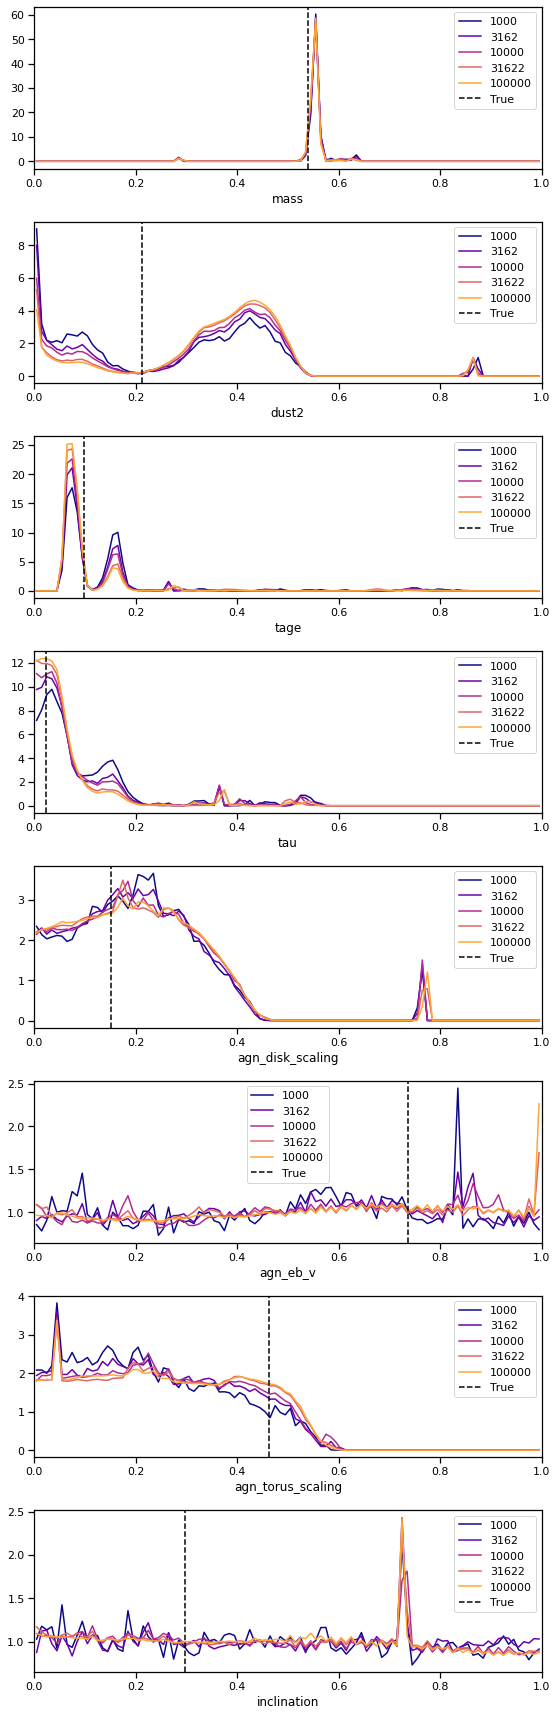

In [28]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

# limits = [
#     [0., 1.],
# #     [.5, .6],
#     [.1, .5],
#     [0., .2],
#     [0., 0.2],
#     [0., 0.7],
#     [0., 1.],
#     [0., 0.6],
#     [0., 1.]
# ]
limits = [[0., 1.] for _ in range(len(params))]

cuts = np.logspace(3, np.log10(len(by_chain)), num=5).astype(int)
# tau_est = np.array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453]) / 10.

max_chains = 64

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(cuts):
        marginals, bins = get_marginals(by_chain[:cut, :max_chains, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=cut)
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()
    

### Marginals, cut by n-chains

Note that this is only relevant for HMC, as the performance by-chain for emcee is not defined - chains are dependent!

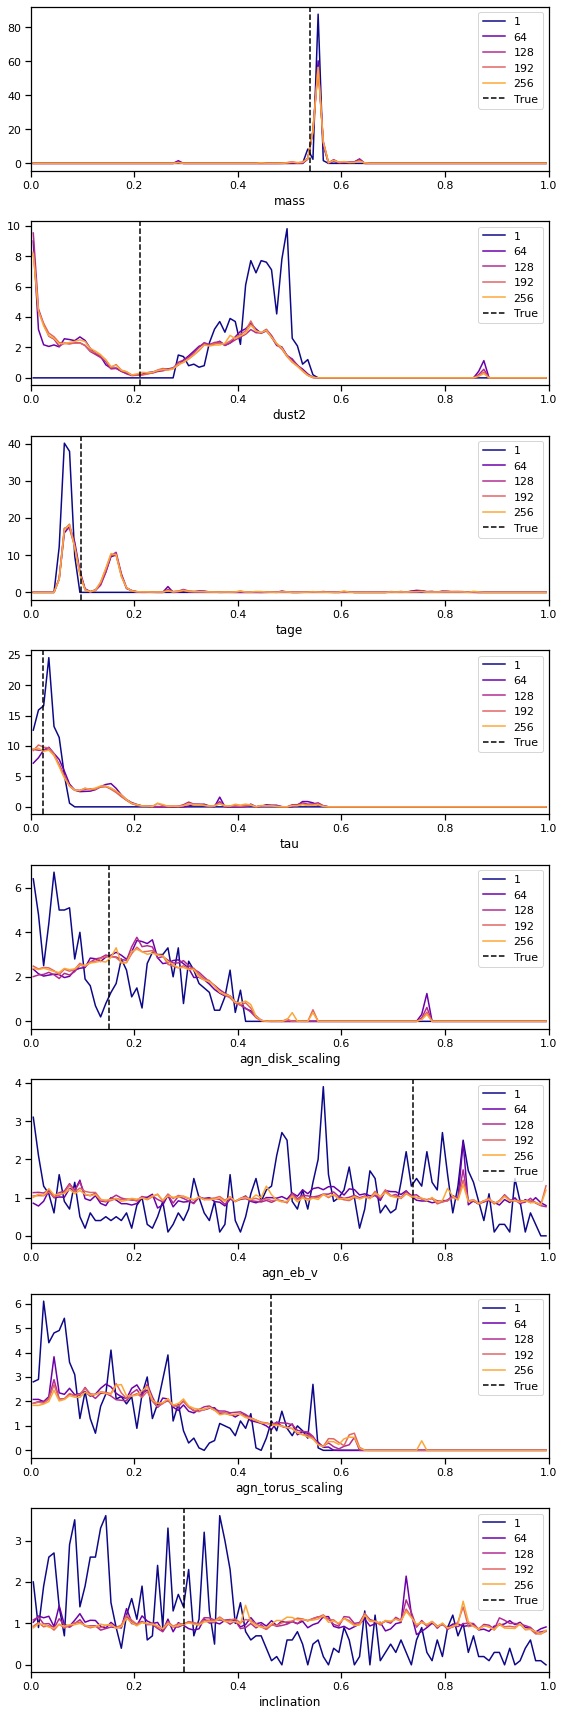

In [30]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, by_chain.shape[1], num=5).astype(int)
max_samples = 1000

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain[:max_samples, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

In [ ]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [108]:
ds = az.convert_to_dataset(np.swapaxes(by_chain, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity
ds_hmc = az.convert_to_dataset(np.swapaxes(by_chain_not_bad, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [62]:
ds

<xarray.Dataset>
Dimensions:  (chain: 256, draw: 100000, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 99994 99995 99996 99997 99998 99999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float16 0.539 0.364 0.0713 ... 0.539 0.3987
Attributes:
    created_at:  2020-02-21T15:42:56.039104

In [ ]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

In [ ]:
sns.kdeplot()

In [ ]:
np.argmax(np.median(by_chain[:, :, 0], axis=0))

In [ ]:
plt.plot(by_chain[:, 34, 0])
plt.plot(by_chain[:, 0, 0])
plt.plot(by_chain[:, 1, 0])
plt.plot(by_chain[:, 2, 0])

In [ ]:
from agnfinder.tf_sampling import deep_emulator

In [ ]:
import tensorflow as tf

In [ ]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])

In [ ]:
checkpoint_dir = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=False)

In [ ]:
fixed_params = galaxy['fixed_params'].reshape(1, -1)
fixed_params

In [ ]:
def get_expected_photometry(x):
    x_with_fixed_params = tf.concat([fixed_params, x], axis=1)
    return deep_emulator.denormalise_photometry(emulator(x_with_fixed_params, training=False)).numpy()

In [ ]:
x = np.random.rand(8).reshape(1, -1)

In [ ]:
fixed_params.shape, x.shape

In [ ]:
np.concatenate([fixed_params, x], axis=1)

In [ ]:
get_expected_photometry(x)

In [ ]:
true_params

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true')
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='true params')
# plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=)
for n in range(50):
    plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=0.05)
plt.legend()

In [ ]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0]

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true', color='k')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 34, :].reshape(1, -1))[0], linestyle='', marker='+', color='r')

In [107]:
by_chain_not_bad = np.concatenate([by_chain[:, :34], by_chain[:, 35:]], axis=1)
by_chain_not_bad.shape

(100000, 50, 8)

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, 51, num=5).astype(int)

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain_not_bad[:, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

In [54]:
from emcee.autocorr import integrated_time

In [55]:
# emcee is happy with time, walkers, dimensions
tau_est = integrated_time(by_chain, quiet=True)
tau_est

N/50 = 2000;
tau: [1615.71387706 4802.37264794 5283.37157226 3509.16865897  443.49081106
  290.0977281   584.17799647  286.97366645]


array([1615.71387706, 4802.37264794, 5283.37157226, 3509.16865897,
        443.49081106,  290.0977281 ,  584.17799647,  286.97366645])

In [ ]:
# array([ 628.51810087,  656.14108053,  858.91637139,  925.08219734,
#        1049.84372125, 3584.59257398, 1421.13224327, 3356.72261827])

# hmc

In [59]:
# # emcee is happy with time, walkers, dimensions
# tau_est_not_bad = integrated_time(by_chain_not_bad, quiet=True)
# tau_est_not_bad

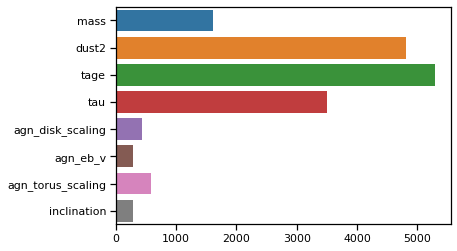

In [56]:
sns.barplot(y=params, x=tau_est)  # estimate tau using all chains

In [57]:
# extinction and inclination are the most uncertain, both almost totally unknown

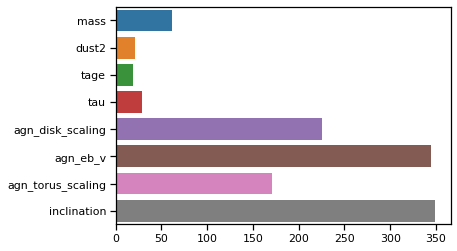

In [58]:
sns.barplot(y=params, x=len(by_chain)/tau_est)  # effective samples per chain

In [ ]:
# hmc, no thinning, 1 chain (probably not a good estimate?):

# array([4594.71930395, 4106.71578812, 3291.08818621, 4068.70526458,
#        2642.20579738, 6012.44976159, 5008.85703236, 5370.88693979])

In [ ]:
# 100k samples, 30k burnin, no thinning, 256 walkers, emcee:
    
# array([4747.67220695, 4897.18058522, 5929.65856414, 5970.30192595,
#        4055.12796419, 2566.78810495, 3377.97829428, 2423.96171419])

# (too short for reliable estimate)

In [ ]:
tau_est * 10  # in real samples, prop.compute time

In [ ]:
# 100k samples, 30k burnin, 10x thinning, 256 walkers, emcee:
    
# array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453])



In [ ]:
# 100k samples HMC, 10k burnin, 10x thinning, 64 walkers, hmc:
    
# array([ 6285.1810087 ,  6561.41080526,  8589.1637139 ,  9250.82197341,
#        10498.43721253, 35845.92573981, 14211.32243268, 33567.22618269])

In [ ]:
geweke = az.geweke(np.swapaxes(galaxy['samples'], 0, 1))
geweke.shape
# plt.plot(geweke[:, 1])

In [ ]:
geweke

In [ ]:
plt.plot(geweke[:, 0])

In [ ]:
rhat = az.rhat(ds)
rhat_values = rhat.x.values
print('Not valid for emcee! walkers are correlated')
print('Values greater than one indicate that one or more chains have not yet converged.')
for n, p in enumerate(params):
    print(p, '{:.2f}'.format(rhat_values[n]))

In [ ]:
# may not be valid for walkers?

In [ ]:
_ = az.plot_autocorr(ds, max_lag=5000, combined=True)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds, max_lag=5000)  # in thinned units

In [ ]:
_ = az.plot_mcse(ds)

In [112]:
ds_hmc

<xarray.Dataset>
Dimensions:  (chain: 50, draw: 100000, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 99994 99995 99996 99997 99998 99999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float16 0.1915 0.259 ... 0.0641 0.6084
Attributes:
    created_at:  2020-02-21T15:51:03.215780

In [109]:
ess = az.ess(ds_hmc)

In [110]:
ess.x.values

array([1654.69484262,  863.10408232,  576.54022403,  949.20526402,
       4231.89554821,  798.11030217, 3203.60832548, 1015.1344035 ])

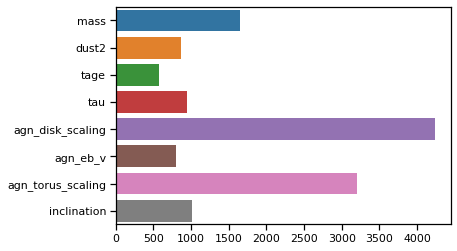

In [111]:
sns.barplot(y=params, x=ess.x.values)

In [ ]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

In [ ]:
_ = az.plot_ess(ds, kind="quantile")

In [ ]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")

In [ ]:
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/backends/backend.py#L130
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/autocorr.py#L47